/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: covariance is not positive-semidefinite.


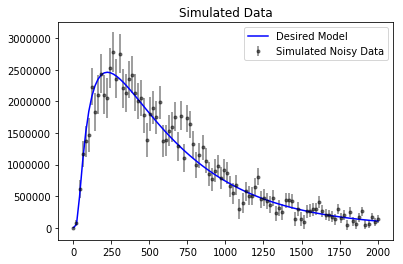

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
import QPP_Funcs as QPP
from scipy.optimize import minimize

#setting our desired parameters that we want to "find"
paramstrue = [1e3, 1e-2, 3.2e+06, 1e+02, 5e+02]
log_paramstrue = np.log(paramstrue)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        '''
        A = np.e**self.log_A
        tau1 = np.e**self.log_tau1
        tau2 = np.e**self.log_tau2
        lam = np.exp(np.sqrt(2*(tau1/tau2)))
        return A*lam*np.exp((-tau1/t)-(t/tau2))
        '''

        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        '''
        A = np.e**self.log_A
        tau1 = np.e**self.log_tau1
        tau2 = np.e**self.log_tau2
        lam = np.exp(np.sqrt(2*(tau1/tau2)))
        dA = (1./A) * self.get_value(t)
        dtau1 = ((1/(tau2 * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(tau2**2)) - (tau1/((tau2**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        '''
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        dA = (1./np.exp(self.log_A)) * self.get_value(t)
        dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(np.exp(self.log_tau2)**2)) - (np.exp(self.log_tau1)/((np.exp(self.log_tau2)**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        
    #somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        prob = np.e
        T=2000.
        if not (self.log_A>-np.inf and self.log_A<np.log(3.5e7)) and (self.log_tau1>-np.inf and self.log_tau1<np.log(T)) and (self.log_tau2>-np.inf and self.log_tau2<np.log(T)):
            return -np.inf
        return np.log(prob)

model = CTSModel_prior(log_A = log_paramstrue[2], log_tau1 = log_paramstrue[3], log_tau2 = log_paramstrue[4])    

class RealTerm_Prior(ce.terms.RealTerm):

    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_a > np.log(0)) and (self.log_a < np.log(1e6))):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c * np.e)



def simulate(x, yerr, model, kernel):
    #generates a covariance matrix and then data using the multivariate normal distribution
    #could this be where the error is????
    K = kernel.get_value(x[:, None] - x[None, :])
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return np.abs(y)

truekernel =  RealTerm_Prior(log_a = log_paramstrue[0], log_c = log_paramstrue[1])

#generating our simulated data
N = 100
x = np.linspace(1,2001,N)
ytrue = simulate(x, np.zeros(len(x)), model, truekernel)
yerrscale = 2e2
yerr = np.sqrt(ytrue) * yerrscale
plt.plot(x, ytrue, 'b-', label = "Desired Model")

ysim = simulate(x, yerr, model, truekernel)

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()
plt.show()


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Initial log-likelihood: -1331.3819944
True log-likelihood: -1331.38190535
Final log-likelihood: -1330.33578492
      fun: 1330.3357849163344
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.04071487e-04,   4.13712890e-91,   4.93049461e-08,
         2.33793962e-03,   7.35049553e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 13
   status: 0
  success: True
        x: array([  6.50998959,   2.30258509,  14.98604359,   4.6388731 ,   6.22952561])


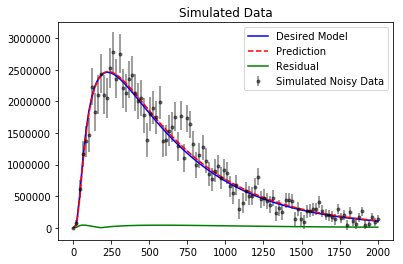

In [2]:
#define a class for our kernel function in celerite
class RealTerm_Prior(ce.terms.RealTerm):

    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_a > np.log(0)) and (self.log_a < np.log(1e6))):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c * np.e)


#initializing kernal and GP
kernel = RealTerm_Prior(log_a = np.log(500), log_c = np.log(10))

gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

#defining fitting functions for our GP
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#setting initial terms and then optimizing
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

gp.set_parameter_vector(log_paramstrue)
print("True log-likelihood: {0}".format(gp.log_likelihood(ysim)))

gp.set_parameter_vector(initial_params)
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print soln
ytest, yvar = gp.predict(ysim, x, return_var=True)
ystd = np.sqrt(yvar)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r--', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [3]:
#choosing a startpoint from our optimizer (ignoring kernel terms because the optimizer messes those up for some reason)

paramstart = soln.x
gp.set_parameter_vector(paramstart)
gp.compute(x, yerr)
#probability function for MCMC
def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not (np.isfinite(gp.log_likelihood(y))):
        return np.inf
    if not (np.isfinite(lp)):
        return -np.inf
    return gp.log_likelihood(y) + lp


#sampling function for mcmc
def samplepdf(params):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params)/7500.))



In [4]:
#initializing and running emcee sampler using same startpoint as MH-MCMC

import emcee
import corner

ndim = 5
nwalkers = 100
nsteps = 500
start = [samplepdf(paramstart) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysim, gp))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)
/usr/local/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  1.33684665e+03,  -2.23980257e+00,   1.49964037e+01,
           4.57307361e+00,   6.23113714e+00],
        [  8.71888285e+02,  -8.11740912e+00,   1.49841846e+01,
           4.82165033e+00,   6.21541399e+00],
        [  1.02388201e+03,   5.84360066e-01,   1.49540416e+01,
           4.71319860e+00,   6.22938743e+00],
        [  1.01125505e+03,   1.38559767e+00,   1.50165716e+01,
           4.77387992e+00,   6.19452576e+00],
        [  1.98255255e+03,   1.70720441e-01,   1.49588485e+01,
           4.85400492e+00,   6.21181977e+00],
        [  1.38850365e+03,  -8.70812213e+00,   1.49753950e+01,
           4.37682127e+00,   6.23927675e+00],
        [  3.46390246e+04,  -7.19982342e+00,   1.49963041e+01,
           4.72403271e+00,   6.26594296e+00],
        [  7.69530331e+04,  -3.70001095e+00,   1.50832961e+01,
           4.94446426e+00,   6.15893089e+00],
        [  1.14433143e+03,   6.29851719e-01,   1.49665837e+01,
           4.55067746e+00,   6.27077585e+00],
        [  1.399009

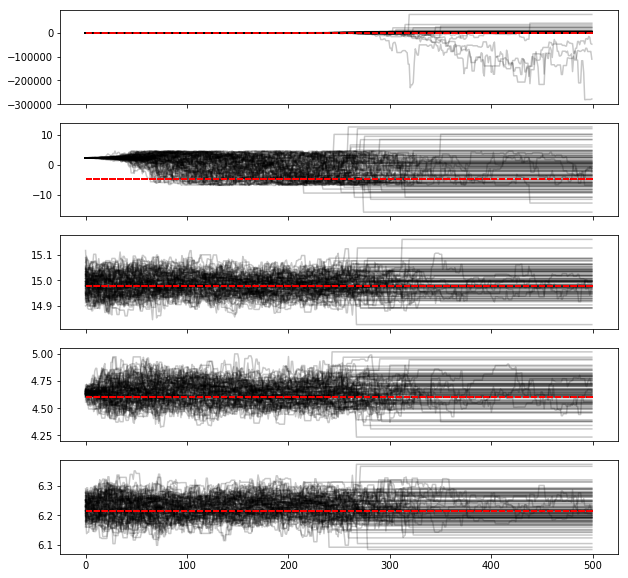

In [5]:
fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramstrue[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
plt.show()

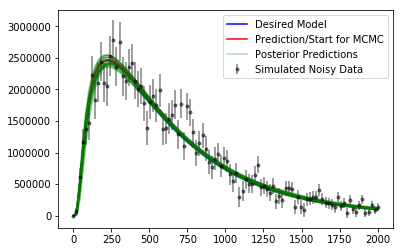

In [6]:
#plotting a sampling of results from emcee MCMC along with my previous work

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction/Start for MCMC")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")


labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gp.set_parameter_vector(params)
    
    ymc, ymcvar = gp.predict(ysim, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.3)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')

plt.legend()    
plt.show()

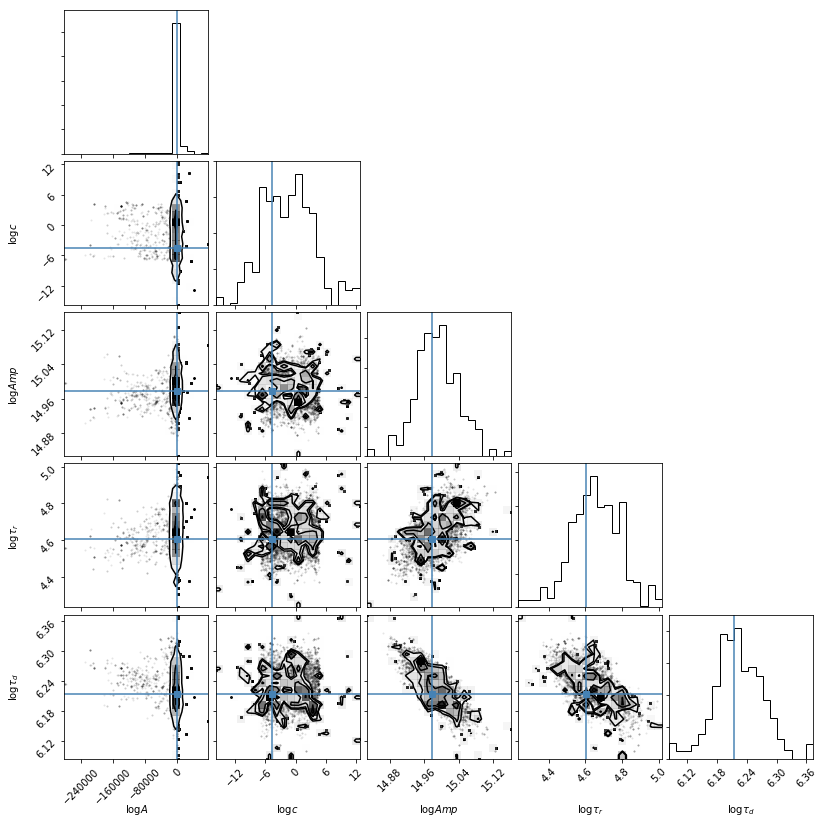

[  6.90775528  -4.60517019  14.97866137   4.60517019   6.2146081 ]


In [7]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, labels = [r"$\log{A}$", r"$\log{c}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = log_paramstrue)
plt.show()
print log_paramstrue

In [14]:
lnp = []
for i in range(nwalkers):
    lnp.append(log_probability(sampler.chain[i,nsteps-1,:], ysim, gp))
    
plt.hist(lnp)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


ValueError: range parameter must be finite.